[Model] Model Compiled
Time taken: 0:00:00.980122
[Model] Training Started
[Model] 2 epochs, 32 batch size, 124 batches per epoch
Epoch 1/2
124/124 [==============================] - 13s 66ms/step - loss: 0.0027
Epoch 2/2
124/124 [==============================] - 8s 63ms/step - loss: 8.2963e-04
[Model] Training Completed. Model saved as saved_models\28022021-150358-e2.h5
Time taken: 0:00:21.160284
[Model] Predicting Sequences Multiple...


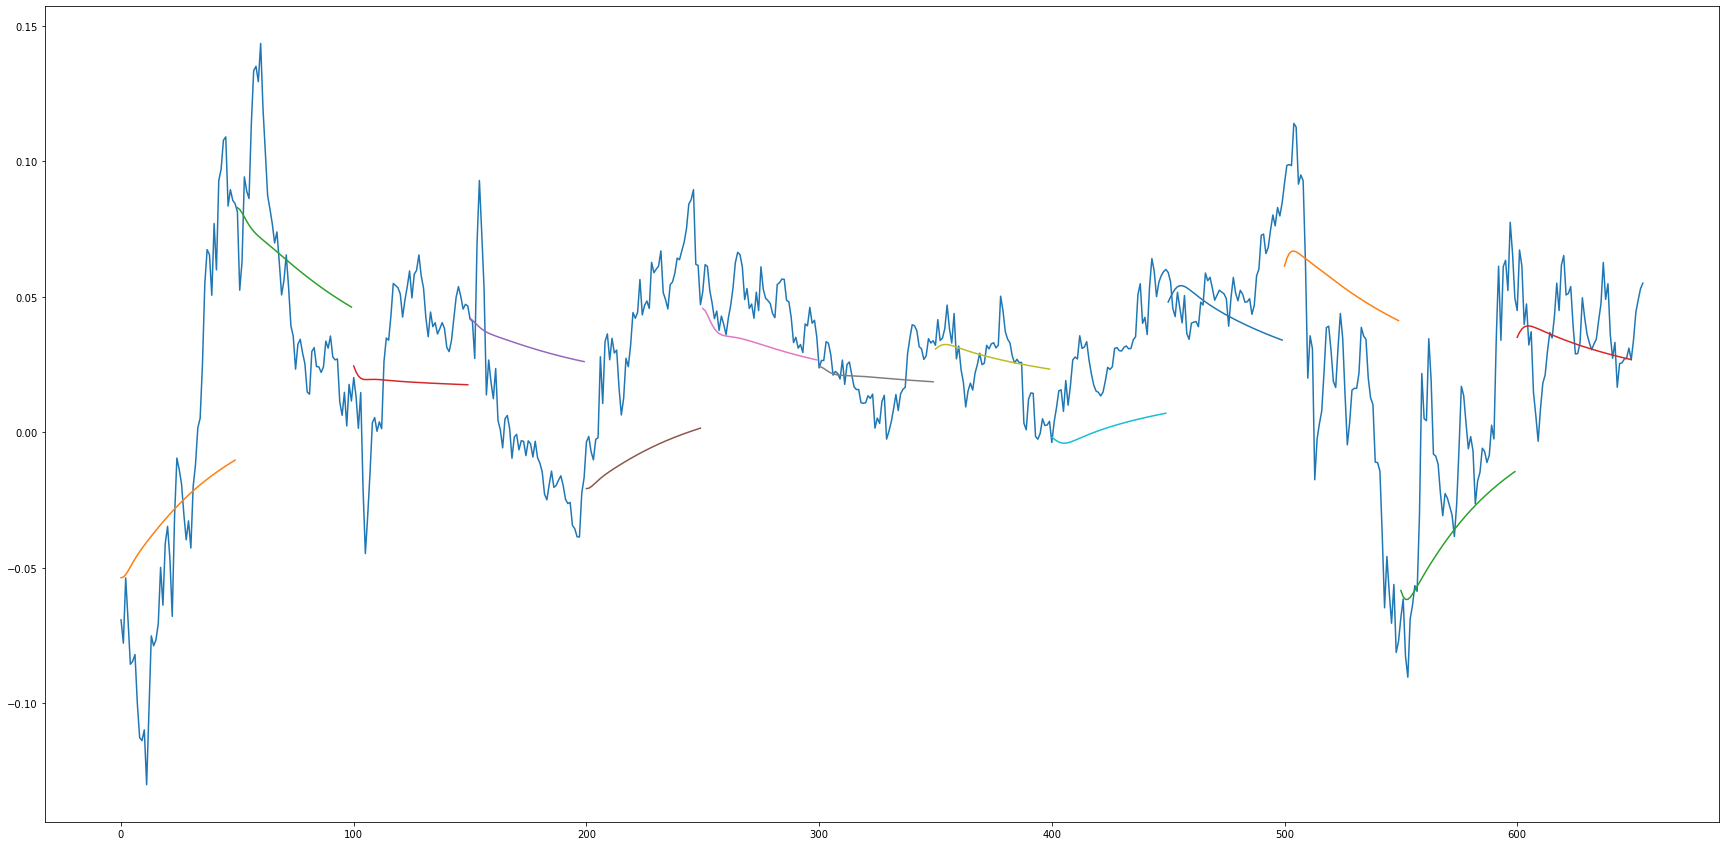

In [1]:
__author__ = "Jakob Aungiers"
__copyright__ = "Jakob Aungiers 2018"
__version__ = "2.0.0"
__license__ = "MIT"

#!pip install keras
#!pip install tensorflow

import os
import json
import time
import math
import matplotlib.pyplot as plt
from core.data_processor import DataLoader
from core.model import Model


def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white', figsize=(30, 15))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    #plt.legend()
    plt.show()


def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white', figsize=(30, 15))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
	# Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        #plt.legend()
    plt.show()


def main():
    configs = json.load(open('config.json', 'r'))
    if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

    data = DataLoader(
        os.path.join('data', configs['data']['filename']),
        configs['data']['train_test_split'],
        configs['data']['columns']
    )

    model = Model()
    model.build_model(configs)
    x, y = data.get_train_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )

    '''
	# in-memory training
	model.train(
		x,
		y,
		epochs = configs['training']['epochs'],
		batch_size = configs['training']['batch_size'],
		save_dir = configs['model']['save_dir']
	)
	'''
    # out-of memory generative training
    steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
    model.train_generator(
        data_gen=data.generate_train_batch(
            seq_len=configs['data']['sequence_length'],
            batch_size=configs['training']['batch_size'],
            normalise=configs['data']['normalise']
        ),
        epochs=configs['training']['epochs'],
        batch_size=configs['training']['batch_size'],
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir']
    )

    x_test, y_test = data.get_test_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )

    predictions = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
    # predictions = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
    # predictions = model.predict_point_by_point(x_test)

    plot_results_multiple(predictions, y_test, configs['data']['sequence_length'])
    # plot_results(predictions, y_test)


if __name__ == '__main__':
    main()